In [1]:
import numpy as np
import pandas as pd

In [2]:
want_new_data = False

if want_new_data:
    data = pd.read_pickle('crafted_data/playlists_and_trackid.pkl')
    data = data[data['num_tracks_id'] >= 10]
    max_length = max(data['num_tracks_id'])

    numerical_values = pd.read_pickle('src/tracks_numerical_features.pkl')
    numerical_values = numerical_values.set_index('id')
    X = []
    y = []
    for playlist in data['tracks']:
        curr = []
        for i in range(len(playlist)):
            
            song_id = playlist[i]
            if (i == len(playlist) - 1):
                y.append(np.array(numerical_values.loc[song_id].values))
            else:
                curr.append(np.array(numerical_values.loc[song_id].values))
        to_pad = max_length - len(curr) - 1
        tmp = np.array(curr)
        tmp = np.pad(tmp, pad_width=((to_pad,0), (0,0)), mode='constant')
        X.append(np.array(tmp))
    X = np.array(X)
    y = np.array(y)
    np.save('crafted_data/X', X)
    np.save('crafted_data/y', y)
else:
    X = np.load('crafted_data/X.npy')
    y = np.load('crafted_data/y.npy')

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (2058, 120, 13)
y shape:  (2058, 13)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y[:,1], test_size=0.20, random_state=42)

In [4]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, load_model
from keras.datasets import boston_housing
from keras.losses import MeanSquaredError

# hyperparameters
INPUT_SIZE = (X.shape[1], X.shape[2], 1)
EPOCHS = 20
BATCH_SIZE = 32
DROPOUT = 0.10
ACTIVATION = 'tanh'
lr = 0.20

#Create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SIZE))
# model.add(Flatten())
# model.add(Dense(1, activation='linear'))

model.add(BatchNormalization())
model.add(Dropout(DROPOUT))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  
model.add(Flatten())
model.add(Dense(256, activation=ACTIVATION))
model.add(Dense(128, activation=ACTIVATION))
model.add(Dense(64, activation=ACTIVATION))
model.add(Dense(32, activation=ACTIVATION))
model.add(Dense(16, activation=ACTIVATION))
model.add(Dense(8, activation=ACTIVATION))
model.add(Dense(4, activation=ACTIVATION))
model.add(Dense(2, activation=ACTIVATION))
model.add(Dense(1, activation=ACTIVATION))

mse = MeanSquaredError()
adam = optimizers.Adam(learning_rate=lr, decay=1e-3)
model.compile(optimizer=adam, loss=mse, metrics = None)

filepath = 'models/cnn/best_cnn_danceability.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 11, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 118, 11, 32)      128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 118, 11, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 9, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 116, 9, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 116, 9, 64)        0

Epoch 1/20


2022-12-05 02:53:41.825371: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


51/52 [============================>.] - ETA: 0s - loss: 1166.1580 - mse: 1166.1580
Epoch 1: val_loss improved from inf to 1195.28406, saving model to models/cnn/best_cnn_danceability.hdf5
52/52 [==============================] - 6s 104ms/step - loss: 1168.0795 - mse: 1168.0795 - val_loss: 1195.2841 - val_mse: 1195.2841
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 1165.4342 - mse: 1165.4342
Epoch 2: val_loss improved from 1195.28406 to 1194.05615, saving model to models/cnn/best_cnn_danceability.hdf5
52/52 [==============================] - 5s 105ms/step - loss: 1165.4342 - mse: 1165.4342 - val_loss: 1194.0562 - val_mse: 1194.0562
Epoch 3/20
51/52 [============================>.] - ETA: 0s - loss: 1162.5599 - mse: 1162.5599
Epoch 3: val_loss improved from 1194.05615 to 1193.37659, saving model to models/cnn/best_cnn_danceability.hdf5
52/52 [==============================] - 5s 99ms/step - loss: 1164.5377 - mse: 1164.5377 - val_loss: 1193.3766 - val_mse: 1193.3766

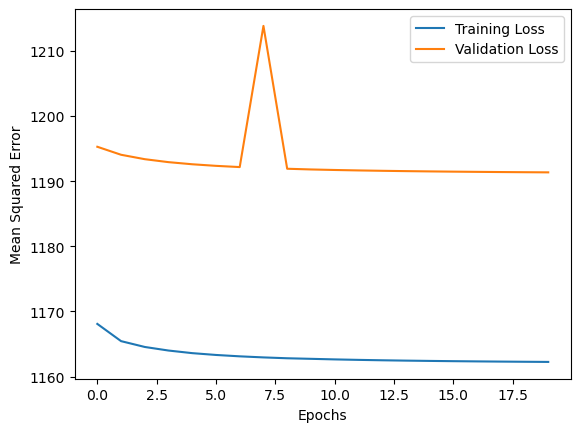

13/13 [==============================] - 0s 18ms/step
Best model MSE on test data =  0.19365318


In [5]:
data = X.reshape(X.shape[0],X.shape[1], X.shape[2], 1)

history = model.fit(data, y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_split=0.2,
                  callbacks=callbacks)

#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('images/cnn_danceability_training_history')
plt.show()

#Load and evaluate the best model version
model = load_model(filepath)
yhat = model.predict(X_test)
print('Best model MSE on test data = ', mse(y_test, yhat).numpy())